# Merge the analysis from 01,02,03 mask analysis notebook from individual mask analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys, os
#from cellpose import io
from skimage import io
from skimage.measure import label, regionprops
import itertools

other_dir_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..','..'))
sys.path.append(other_dir_path)

import IMCprocess.spatial_analysis.mask_utils as mu
import IMCprocess.utils.utils as ut

## Create IMG mask object with cell, cancer and tissue mask

In [19]:
def full_pipeline_IMG_mask(labeled_anndata, img_id, 
                    cell_mask_file, 
                    cancer_mask_file, 
                    tissue_mask_file  ):
    # 1. Get only the object for image R2_002
    Img_adata = labeled_anndata[labeled_anndata.obs['img_id'] == img_id]
    # 2. Create mask object for Cell_mask, cancer_mask and tissue_mask
    Cell_mask = mu.Mask(mask_file=cell_mask_file,
                        img_id=img_id, mask_type='cell_mask')
    Cancer_mask = mu.Mask(mask_file=cancer_mask_file,
                          img_id=img_id, mask_type='cancer_mask')
    Tissue_mask = mu.Mask(mask_file=tissue_mask_file,
                          img_id=img_id, mask_type='tissue_mask')
    # 3. Create Img_mask object
    Img_object = mu.Img_mask(Img_adata, Cell_mask, Cancer_mask, Tissue_mask)

    # 4. plot_outline masks and save in the folder 'output/outline_masks'
    if not os.path.exists('output/outline_masks'):
        os.makedirs('output/outline_masks')
        print("output/outline_masks folder created successfully")
    else:
        print("output/outline_masks Folder already exists")

    print("Plotting outline masks for image {}".format(img_id))
    Img_object.plot_outline_mask(masktype='cell_mask', output_file='output/outline_masks/{}_cell_mask.png'.format(img_id))
    Img_object.plot_outline_mask(masktype='cancer', output_file='output/outline_masks/{}_cancer_mask.png'.format(img_id))
    Img_object.plot_outline_mask(masktype='tissue', output_file='output/outline_masks/{}_tissue_mask.png'.format(img_id))

    # 5. plot outline masks with labels and save in the folder 'output/outline_masks'
    mu.plt_outline_label(Cancer_mask.pixels, 
                         Cancer_mask.mask_regprops,
                         Cancer_mask.mask_labeled,
                         output_file='output/outline_masks/{}_cancer_mask_label.png'.format(img_id))
    mu.plt_outline_label(Tissue_mask.pixels, 
                         Tissue_mask.mask_regprops,
                         Tissue_mask.mask_labeled,
                         output_file='output/outline_masks/{}_tissue_mask_label.png'.format(img_id))

    # 6. check cell_i in cancer_mask and tissue_mask and save in the folder 'output/mask_data'
    if not os.path.exists('output/mask_data'):
        os.makedirs('output/mask_data')
        print("output/mask_data folder created successfully")
    else:
        print("output/mask_data Folder already exists")

    print("Plotting outline masks for image {}".format(img_id))
    cells_in_cancer_tb, cells_in_cancer = mu.create_cell_in_region_table(Cell_mask, Cancer_mask)
    cells_in_cancer_tb.to_csv('output/mask_data/{}_cancer_mask_cells.csv'.format(img_id))
    cells_in_tissue_tb, cells_in_tissue = mu.create_cell_in_region_table(Cell_mask, Tissue_mask)
    cells_in_tissue_tb.to_csv('output/mask_data/{}_tissue_mask_cells.csv'.format(img_id))

    # 7. create cell data table with cells in cancer, tissue, stroma
    # and save in the folder 'output/mask_data'
    all_cells_in_cancer = list(itertools.chain.from_iterable(cells_in_cancer.values()))
    all_cells_in_tissue = list(itertools.chain.from_iterable(cells_in_tissue.values()))
    cells_in_both_cancer_tissue = list(set(all_cells_in_cancer).intersection(
        set(all_cells_in_tissue)))
    cells_in_stroma = list(set(all_cells_in_tissue).difference(cells_in_both_cancer_tissue))
    cells_data = pd.DataFrame({'cells_in_stroma': [cells_in_stroma],
                          'cells_in_cancer': [cells_in_cancer],
                          'cells_in_cancer&tissue': [cells_in_both_cancer_tissue],
                          'num_cells_in_stroma': [len(cells_in_stroma)],
                          'num_cells_in_cancer': [len(cells_in_cancer)],
                          'num_cells_in_cancer&tissue': [len(cells_in_both_cancer_tissue)]
                          })
    cells_data.to_csv('output/mask_data/{}_cells_data.csv'.format(img_id))
    return cells_data
    
    
    

In [20]:
data_path = '/Users/pattama/Desktop/UiB/cancer/example_share_code/share_with_vladan/mask_analysis/example_data/'
data_lev1 = ut.read_pickle_obj(data_path+'00hanna_adata_totalNB_obj_Level1.pkl')

In [21]:
data_lev1.adata_dict

{'level1': AnnData object with n_obs × n_vars = 132951 × 51
     obs: 'img_id', 'PhenoGraph_clusters', 'level1_annotated'
     uns: 'pca', 'PhenoGraph_Q', 'PhenoGraph_k', 'neighbors', 'umap', 'PCs', 'dendrogram_PhenoGraph_clusters', 'PhenoGraph_clusters_colors', 'level1_annotated_colors'
     obsm: 'spatial', 'X_pca', 'X_umap'
     obsp: 'distances', 'connectivities'}

output/outline_masks Folder already exists
Plotting outline masks for image R2_002


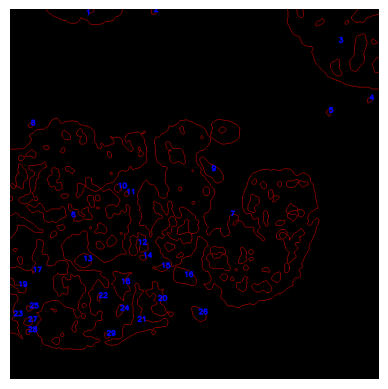

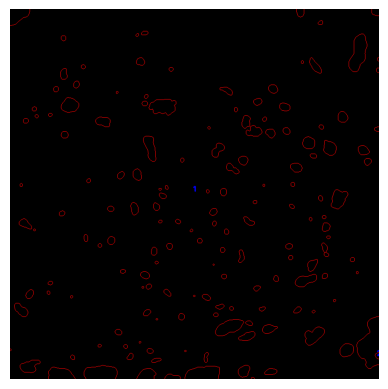

output/mask_data folder created successfully
Plotting outline masks for image R2_002


In [5]:
# create IMG_mask object for image R2_002 that label for level1
cells_data = full_pipeline_IMG_mask(labeled_anndata = data_lev1.adata_dict['level1'], 
                                    img_id='R2_002', 
                                    cell_mask_file=data_path+'Patient2_002.tiff',
                                    cancer_mask_file=data_path+'Patient2_002_cancer_mask.tiff',
                                    tissue_mask_file=data_path+'Patient2_002_tissue_mask.tiff')

In [6]:
# Get only the object for image R2_002
# You can change image name to get other images
obj_level1 = data_lev1.adata_dict['level1']
obj_R2_002_lev1 = obj_level1[obj_level1.obs['img_id'] == 'R2_002']

In [7]:
obj_level1.obs['img_id'].unique()

['R1_001', 'R1_002', 'R1_003', 'R2_001', 'R2_002', ..., 'R9_002', 'R9_003', 'R10_001', 'R10_002', 'R10_003']
Length: 30
Categories (30, object): ['R1_001', 'R1_002', 'R1_003', 'R2_001', ..., 'R9_003', 'R10_001', 'R10_002', 'R10_003']

In [8]:
# Create object for Cell_mask, cancer_mask and tissue_mask
Cell_mask = mu.Mask(mask_file='../example_data/Patient2_002.tiff',
                    img_id='R2_002', mask_type='cell_mask')
Cancer_mask = mu.Mask(mask_file='../example_data/Patient2_002_cancer_mask.tiff',
                    img_id='R2_002', mask_type='cancer_mask')
Tissue_mask = mu.Mask(mask_file='../example_data/Patient2_002_tissue_mask.tiff',
                    img_id='R2_002', mask_type='tissue_mask')

In [9]:
# mask object has mask_df attribute to get the mask data
Tissue_mask.mask_df

,label,area,centroid_x,centroid_y
0,1,588488,390.951374,390.677767
1,2,95,785.936842,742.515789


In [10]:
Img_R2_002 = mu.Img_mask(obj_R2_002_lev1, Cell_mask, Cancer_mask, Tissue_mask)

In [11]:
Img_R2_002.img_mask_adata

View of AnnData object with n_obs × n_vars = 4577 × 51
    obs: 'img_id', 'PhenoGraph_clusters', 'level1_annotated'
    uns: 'pca', 'PhenoGraph_Q', 'PhenoGraph_k', 'neighbors', 'umap', 'PCs', 'dendrogram_PhenoGraph_clusters', 'PhenoGraph_clusters_colors', 'level1_annotated_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [12]:
Tissue_mask.mask_df

,label,area,centroid_x,centroid_y
0,1,588488,390.951374,390.677767
1,2,95,785.936842,742.515789


In [13]:
cell_in_cancer, cell_outside_cancer = mu.cell_in_region(Cell_mask.mask_regprops, Cancer_mask.mask_regprops)

In [14]:
cells_in_tissue_tb = mu.create_cell_in_region_table(Cell_mask, Tissue_mask)

In [15]:
cells_in_tissue_tb

(   label    area  centroid_x  centroid_y  num_cells  \
 0      1  588488  390.951374  390.677767       4577   
 1      2      95  785.936842  742.515789          0   
 
                                      cells_in_region  
 0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
 1                                                 []  ,
 {1: [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
  

In [16]:
obj_R2_002_lev1.obs

,img_id,PhenoGraph_clusters,level1_annotated
Cell_id,,,
21480_4,R2_002,22,Immune
21481_4,R2_002,9,Ep
21482_4,R2_002,14,Fibro
21483_4,R2_002,33,Amb
21484_4,R2_002,14,Fibro
...,...,...,...
26052_4,R2_002,3,Immune
26053_4,R2_002,3,Immune
26054_4,R2_002,41,Undef


In [17]:
Cell_mask.mask_df

,label,area,centroid_x,centroid_y
0,1,43,62.209302,3.023256
1,2,87,84.195402,5.091954
2,3,104,97.500000,3.567308
3,4,55,116.490909,1.963636
4,5,83,147.132530,4.204819
...,...,...,...,...
4572,4573,26,771.692308,790.730769
4573,4574,17,223.294118,791.176471
4574,4575,11,448.363636,791.090909
4575,4576,9,461.666667,791.222222


In [18]:
cell_in_cancer

{1: [2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  34,
  38,
  39,
  40,
  41,
  47,
  48,
  51,
  54,
  55,
  62,
  63,
  68,
  72,
  73,
  78,
  79,
  80,
  83,
  84,
  85,
  92,
  93,
  94,
  100,
  105,
  106,
  117,
  118,
  122,
  123,
  134,
  147,
  148,
  149,
  150,
  155,
  159,
  165,
  166,
  171,
  188],
 2: [64],
 3: [25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  36,
  37,
  44,
  45,
  60,
  66,
  67,
  76,
  81,
  90,
  99,
  103,
  104,
  112,
  113,
  114,
  120,
  121,
  127,
  132,
  133,
  137,
  142,
  144,
  145,
  146,
  153,
  154,
  164,
  169,
  170,
  178,
  182,
  184,
  185,
  195,
  202,
  203,
  204,
  205,
  211,
  214,
  215,
  216,
  221,
  231,
  232,
  233,
  234,
  235,
  241,
  244,
  252,
  253,
  257,
  258,
  259,
  260,
  261,
  276,
  287,
  288,
  289,
  296,
  302,
  303,
  308,
  317,
  318,
  319,
  323,
  324,
  325,
  326,
  332,
  336,
  356,
  357,
  358,
  367,
  373,
  374,
  377,
  378,
  383,
  384,
  389,
  393,
  